<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/Resnext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.6 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.2
    Uninstalling pyparsing-3.1.2:
      Successfully uninstalled pyparsing-3.1.2
  Attempting uninstall: n

- ResNeXt
  - Add groups to a resnet
  - Add g groups cuts down on cost of computation by g
  - Groups will not interact with each other, This can be solved with a pointwise cnn
  

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import copy
from torch.utils.data import RandomSampler
import numpy as np
import torchvision

device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

device(type='cuda')

In [ ]:
class ResNextblock(nn.Module):
  def __init__(self, input_channels, output_channels, bottleneck_channels=64, group_channels=4, stride=1, drop_out_prob=0.1) -> None:
    super(ResNextblock, self).__init__()
    self.encoder = nn.Conv2d(input_channels, bottleneck_channels, kernel_size=1, stride=1, padding=0)

    self.conv1 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1)
    self.bn1 = nn.BatchNorm2d(bottleneck_channels)
    self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(bottleneck_channels)

    self.conv3 = nn.Conv2d(input_channels, output_channels, kernel_size=3, stride=stride, padding=1)

    self.decoder = nn.Conv2d(bottleneck_channels, output_channels, kernel_size=1, stride=1, padding=0)
    self.stochastic_depth = torchvision.ops.StochasticDepth(p=drop_out_prob, mode='row')

    self.input_channels = input_channels
    self.output_channels = output_channels

  def forward(self, x):
    out = self.encoder(x)
    out = self.conv1(out)
    out = self.bn1(out)
    out = F.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = F.relu(out)
    out = self.decoder(out)

    if self.input_channels != self.output_channels:
      x = self.conv3(x)
    return F.relu(self.stochastic_depth(out) + x)


res_block = ResNextblock(1, 64, stride=2)
dummy_input = torch.randn(1, 1, 224, 224)
res_block(dummy_input).shape

torch.Size([1, 64, 112, 112])

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class Resnext(d2l.Classifier):
  def __init__(self, num_classes=10, lr=0.1) -> None:
    super(Resnext, self).__init__()

    bottleneck = nn.Sequential(*[
      nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
      nn.BatchNorm2d(64),
      nn.ReLU()],
      nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )
    self.lr = lr

    self.net = nn.Sequential(*[
      bottleneck,

      ResNextblock(64, 64),
      ResNextblock(64, 64),

      ResNextblock(64, 128, stride=2),
      ResNextblock(128, 128),

      ResNextblock(128, 256, stride=2),
      ResNextblock(256, 256),

      ResNextblock(256, 512, stride=2),
      ResNextblock(512, 512),

      ResNextblock(512, 512),
      ResNextblock(512, 512),
      ResNextblock(512, 512),
      ResNextblock(512, 512),
      ResNextblock(512, 512),
      ResNextblock(512,512),


      nn.AdaptiveAvgPool2d(1),
      nn.Flatten(),
      nn.Linear(512, 10)
    ])

  def forward(self, x):
    return self.net.forward(x)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    total_params = 0
    for layer in self.net:
      X = layer(X)
      params = sum([p.numel() for p in layer.parameters()])
      print(layer.__class__.__name__, "output shape = ", X.shape, "Mparams = ", params/1e6)
      total_params += params
    print("Total params In M = ", total_params / (1e6))

res_net = Resnext()
dummy_input = torch.randn(1, 1, 224, 224)
res_net.layer_summary(dummy_input.shape)

Sequential output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.003328
ResNextblock output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.11936
ResNextblock output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.11936
ResNextblock output shape =  torch.Size([1, 128, 28, 28]) Mparams =  0.160448
ResNextblock output shape =  torch.Size([1, 128, 28, 28]) Mparams =  0.238272
ResNextblock output shape =  torch.Size([1, 256, 14, 14]) Mparams =  0.394176
ResNextblock output shape =  torch.Size([1, 256, 14, 14]) Mparams =  0.69728
ResNextblock output shape =  torch.Size([1, 512, 7, 7]) Mparams =  1.304
ResNextblock output shape =  torch.Size([1, 512, 7, 7]) Mparams =  2.500032
ResNextblock output shape =  torch.Size([1, 512, 7, 7]) Mparams =  2.500032
ResNextblock output shape =  torch.Size([1, 512, 7, 7]) Mparams =  2.500032
ResNextblock output shape =  torch.Size([1, 512, 7, 7]) Mparams =  2.500032
ResNextblock output shape =  torch.Size([1, 512, 7, 7]) Mparams =  2.500032
ResNextbl

In [ ]:
class SampleFashionMNIST(d2l.FashionMNIST):
  def __init__(self, batch_size, resize=(28, 28)) -> None:
    super(SampleFashionMNIST, self).__init__(batch_size, resize)

  def get_dataloader(self, train, num_samples=1000):
    data = self.train if train else self.val
    random_sampler = RandomSampler(data, num_samples=num_samples)
    return torch.utils.data.DataLoader(data, self.batch_size,
                                           num_workers=self.num_workers, sampler=random_sampler)

training_data = d2l.FashionMNIST(batch_size=400, resize=(224, 224))
testing_data = d2l.FashionMNIST(batch_size=40, resize=(224, 224))
sample_mnist = SampleFashionMNIST(batch_size=256)
sample_mnist.get_dataloader(train=True, num_samples=1)

In [ ]:
def train_resnet(data, max_epochs=10):
  trainer = d2l.Trainer(max_epochs=max_epochs, num_gpus=1)
  res_net = Resnext(lr=0.05)
  res_net.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
  trainer.fit(res_net, data)
  return res_net

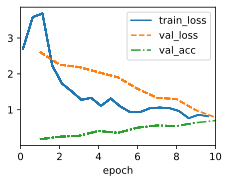

In [ ]:
_ = train_resnet(sample_mnist)

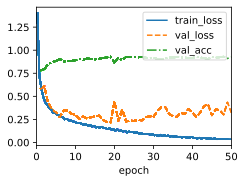

In [ ]:
def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs.to(device))
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))

resnet = train_resnet(training_data, max_epochs=50)

In [ ]:
get_loss(resnet, testing_data)

(0.32100671776337547, 0.9248000133037567)